<a href="https://colab.research.google.com/github/AiDAPT-A/2024-Q3-ai-in-architecture/blob/main/tutorials/T7_From_Graphs_to_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **From Graphs to Similarity: Comparing Floor Plans Using Pre-trained Neural Nets**

This tutorial is about investigating floor layout similarity using pre-trained deep neural networks specialized in extracting layout-specific features.
The idea is to use the code for your final projects, and manipulate / tune where needed.

<center>
<img src="https://drive.google.com/uc?export=view&id=1BhzBUPXqtDs2DZ8YfWr3NBsmJUgLrd6f" alt="AI-and-floorplans" class="center" width="1200px">
</center>

Before we start, we need two install to important libraries in order to run the pre-trained models on our data: `OmegaConf` and `Pytorch Geometric`.
This might take some time to install.
And, slightly annoyingly so, you might need to restart the kernel after the packages are installed $\rightarrow$ Press `Runtime/Restart Session` on the top of the page.

In [ ]:
import torch
import os

# Install OmegaConf
!pip install omegaconf

# Pytorch Geometric (PyG) must be installed.
# PyG isn't a default package in Google Collab.
# Takes ~10-15 minutes.
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 1.5 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144555 sha256=b21582ba8b83a6e4de119b693121532afb48c33ff91999d8391eff161fb7b991
  Stored in directory: /root/.cache/pip/wheels/1a/97/32/461f837398029ad76911109f07047fde1d7b661a147c7c56d1
Successfully built antlr4-python3-runtime


2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 3.8 MB/s eta 0:00:00


## **(1) The model: from graphs to embeddings**

Interested in the background of the model's details, the training procedure, and the data used to develop the pre-trained model?
Here are some insights.
The embeddings come from a pre-trained model for which the floor plan graphs are the inputs.
The model itself is very similar to that of [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/abs/1609.02907), commonly know as *Graph Convolution Networks* (GCNs) for which a nice explanation is given [here](https://tkipf.github.io/graph-convolutional-networks/) (note: quite mathematically heave !).
The pre-trained model is trained on the [RPLAN](http://staff.ustc.edu.cn/~fuxm/projects/DeepLayout/index.html) dataset - a publicly available floor plan layout dataset.
RPLAN is first cleaned (to get rid of near-duplicates and unconnected layouts) and similarity labels for training are sampled based on the ranking algorithm developed in a previous paper of our $\rightarrow$ [Paper in ICCVW](https://arxiv.org/abs/2309.04357); [Code on GitHub](https://arxiv.org/abs/2309.04357).

In this tutorial, we will test it's generalizibility to the MSD dataset that we recently brought out $\rightarrow$ [Paper in ECCV](https://arxiv.org/abs/2407.10121); [Code on GitHub](https://github.com/caspervanengelenburg/msd); [Data on Kaggle](https://www.kaggle.com/datasets/caspervanengelenburg/modified-swiss-dwellings).


### **Self-curated Python library**

Similar to T3, we will 'install' ***our own library*** with some functions that we will use throughout this tutorial.
There is ***no need to understand what happens inside*** these functions.
(Of course, if you are curious, please have a look!).
Instead, ***you'll need to understand how to use them***.
This will become clear when we need them!

In [ ]:
# 1. Function that can load .py files as libraries (See T3 for details.)
import requests

def url2libary(url):
    r = requests.get(url)
    with open('utils.py', 'w') as f:
        f.write(r.text)

And load the Python library pertaining to T7 $\rightarrow$ [Function library T7](https://github.com/AiDAPT-A/2024-Q3-ai-in-architecture/blob/main/tutorials/t7_functions.py).

In [ ]:
# 2. Load our own library
# If you are using GitHub, make sure you get the "Raw" version of the code
url = r'https://raw.githubusercontent.com/AiDAPT-A/2024-Q3-ai-in-architecture/refs/heads/main/tutorials/t7_functions.py'

# Create a library from the raw file
url2libary(url)

### **Load model and data**

A ***checkpoint*** of the model and the datasets of graphs can be found in our *Google Drive* $\rightarrow$ [Pre-trained model and graph data](https://drive.google.com/drive/u/0/folders/10DqRfW2RUNfsvNkhFPXn5yKhSGeHIQkK).
Please download all files from the folder.

We first mount our *Google Drive*.

In [ ]:
import os
from google.colab import drive

# Mounts drive (> See T2)
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Next, we load the model and push it (if Collaborary allows it at least) to GPU.
CPU is also fine yet a little bit slower.

In [ ]:
import omegaconf
import torch

# Imports from own library
from utils import GraphSiameseNetwork

# Filename of model
filename = r'/content/drive/MyDrive/academia/8 data/HouSim/GEN - W&B = expert-pine-3.pth.tar'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Load checkpoint, including its state, and its configurations
checkpoint = torch.load(filename, map_location=device, weights_only=False)
state_dict = checkpoint['state_dict']
cfg = checkpoint['config']

# Load model
model = GraphSiameseNetwork(cfg)
model.load_state_dict(state_dict)

# Print configurations
print(omegaconf.OmegaConf.to_yaml(cfg))

geom_dim: 6
edge_type: door
inter_geom_dim: 2
cats_dim: 13
node_dim: 128
edge_dim: 128
graph_dim: 1024
num_layers: 5
matching: false
message_gain: 0.1
graph_reg: false
graph_vec_weight: 1.0e-06
aggr: add
cuda: true
distance: margin
margin: 1
n_epochs: 100
lr: 0.0001
bs: 32
step: 10
graph_type: universal
sparse_graphs: true
p_axes: 0.2
p_points: 0.05
margin_axes: 0.1
margin_points: 0.1
path_checkpoint: .\checkpoints
path_triplets: C:\Users\caspervanengel\OneDrive\Documents\PHD\1_data\rplan\0-full\RPLAN
  Triplets MIoU Universal (Train)
path_data: \Users\caspervanengel\OneDrive\Documents\PHD\1_data\rplan\0-full
print_freq: 100



Next, we load the floor plan datasets.
The datasets are both saved as lists of (`networkx`) graphs.

In [ ]:
from utils import load_pickle  # Note: own library

# Get RPLAN and MSD graphs
# TODO: Change to other directory (shared one!)
graphs_rplan = load_pickle(r'/content/drive/MyDrive/academia/8 data/HouSim/RPLAN - Graphs.pickle')
graphs_msd = load_pickle(r'/content/drive/MyDrive/academia/8 data/HouSim/MSD - Graphs.pickle')

We extract the floor plans' names.
The names are the identities (IDs), which are saved in the ***graph-level attribute*** called `"ID"`.

In [ ]:
ids_rplan = [G.graph['ID'] for G in graphs_rplan]
ids_msd = [G.graph['ID'] for G in graphs_msd]

print(ids_msd[:5])

['3c3b1d6ca8b4b9092480b8c75f9eaa81', 'dd7f04c697c2d6ba20587aad0f95b928', 'e0fb6e7bbcb6b33706b7013cf3664873', 'c0d2c1a6c9d8c09bd0dd7d52858bb45d', '39ad522a53b5bc9873a7bbce2acfa68c']


Let's have a look at the ***size of the dataset*** (i.e., the number of floor plans).
As you'll know by now, the size can be checked by the length of the list.

In [ ]:
print(f"Amount of floor plans RPLAN: {len(graphs_rplan)}")
print(f"Amount of floor plans MSD: {len(graphs_msd)}")

Amount of floor plans RPLAN: 46063
Amount of floor plans MSD: 16692


Let's ***plot*** a couple of floor plans from the RPLAN dataset.

For this we ***randomly sample the graphs***, using the `sample` function from the library `random`.
The number of samples can be set by the keyword argument `k`.

For reproducibility we set the same 'seed'.
If you want to see other floor plans, either remove or comment the line `random.seed(42)` or change the seed's number (which is now 42) to another number.

We choose here to visualize 30 floor plans (3 by 10).
You can modify the values `nr` to `nc` accordingly.



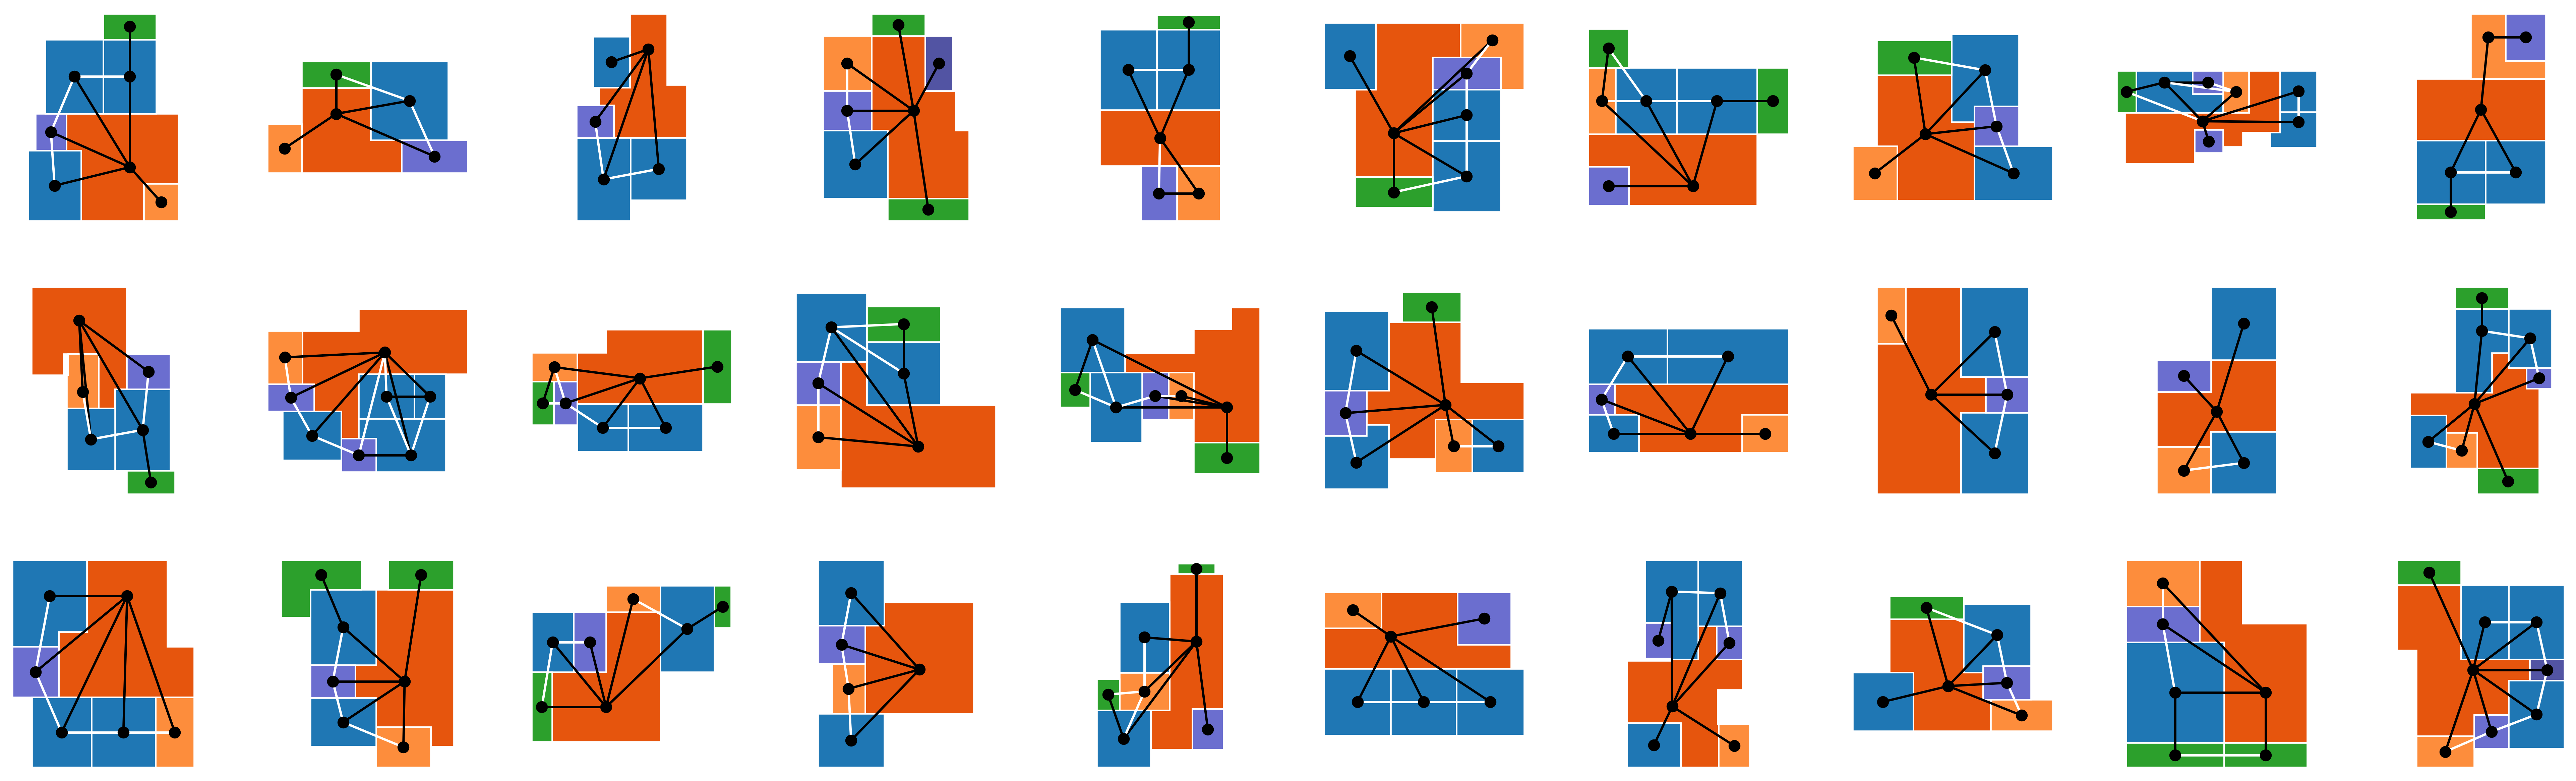

In [ ]:
import random
import matplotlib.pyplot as plt

from utils import draw_graph

# Set figure and specs
fs = 10
nc, nr = 10, 3
fig, axs = plt.subplots(nr, nc, figsize=(fs*nc, fs*nr))
axs = axs.flatten()

# Randomly sample graphs
random.seed(12)
graphs_random = random.sample(graphs_rplan, k=nc*nr)

# Loop through apartments
for ax, G in zip(axs, graphs_random):

    # Set axis
    ax.set_aspect('equal')
    ax.axis('off')

    # Plot floor plan + graph
    draw_graph(ax, G, fs=fs, s=fs*60, w=fs/2, lw=fs/3)

And a couple for the MSD dataset:

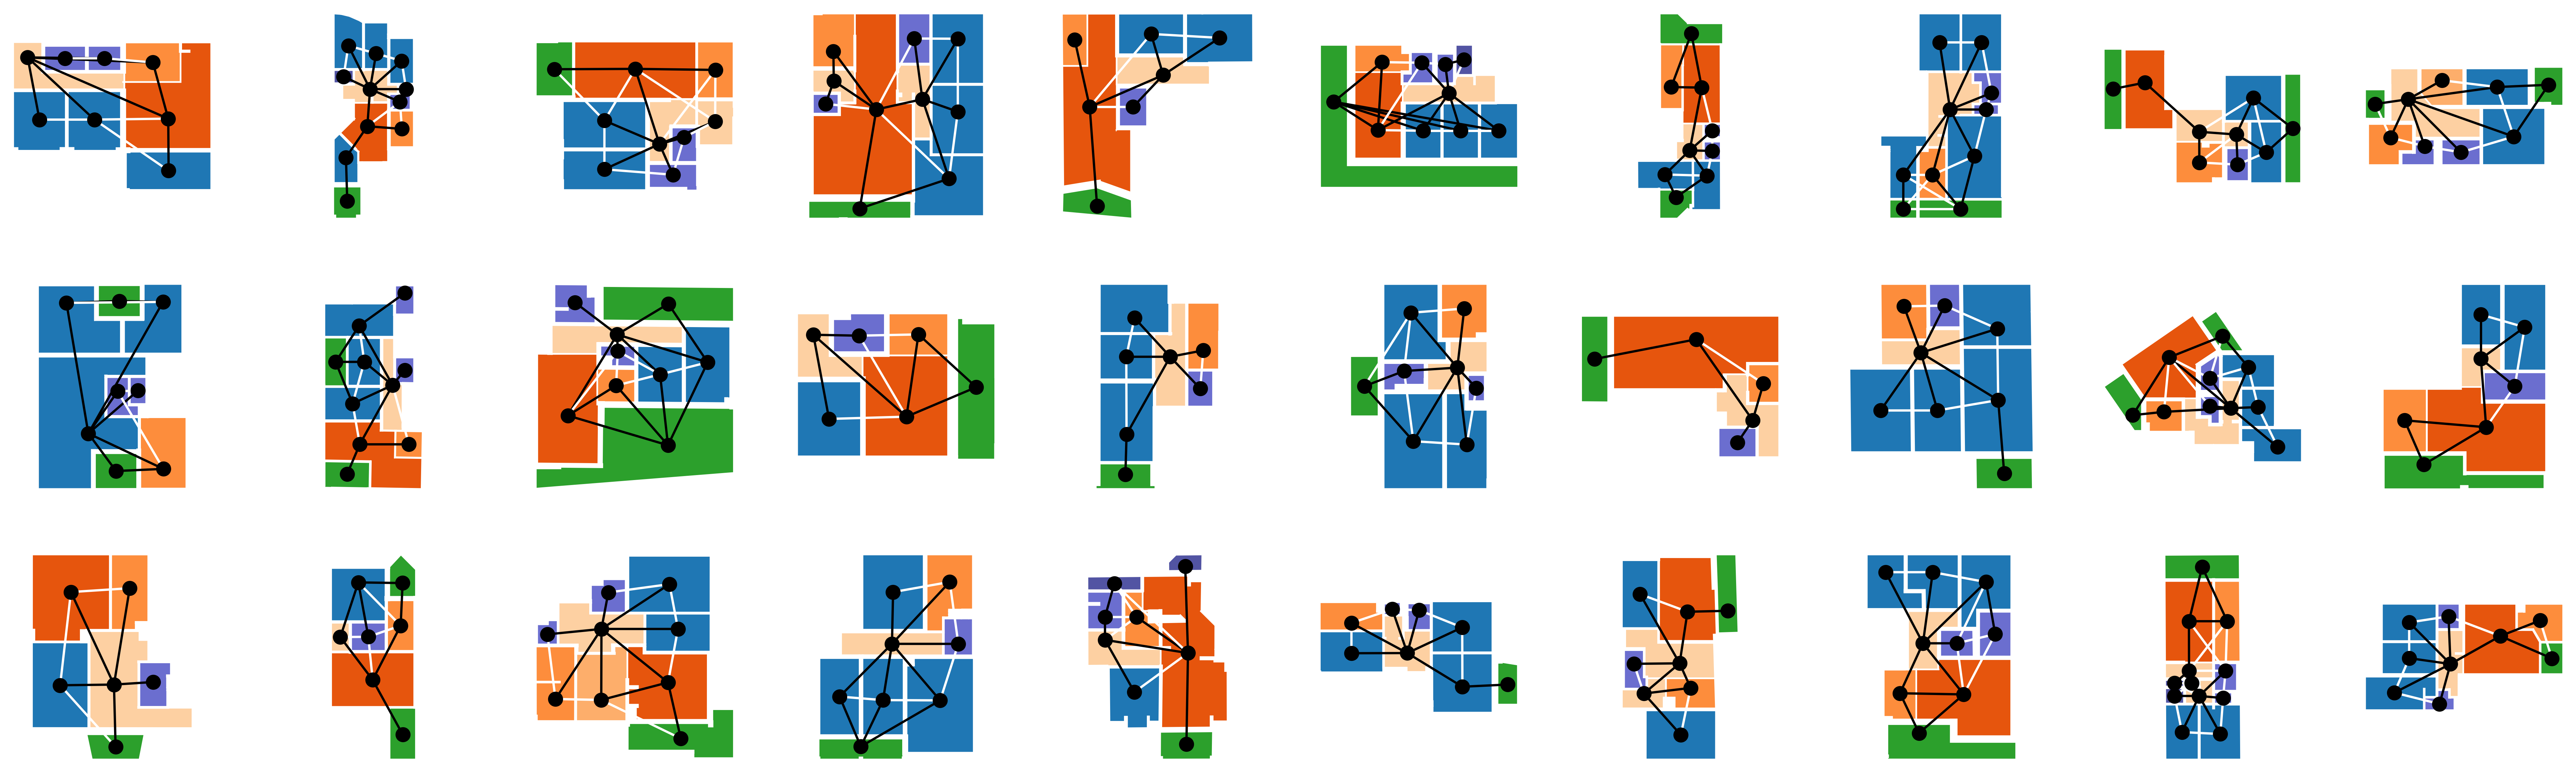

In [ ]:
# Set figure and specs
fs = 10
nc, nr = 10, 3
fig, axs = plt.subplots(nr, nc, figsize=(fs*nc, fs*nr))
axs = axs.flatten()

# Randomly sample graphs
random.seed(42)
graphs_random = random.sample(graphs_msd, k=nc*nr)

# Loop through apartments
for ax, G in zip(axs, graphs_random):

    # Set axis
    ax.set_aspect('equal')
    ax.axis('off')

    # Plot floor plan + graph
    draw_graph(ax, G, fs=fs, s=fs*100, w=fs/2, lw=fs/3)

### **Feedforward: get embeddings**

The next step is to feedforward the data throught the pre-trained model.


In [ ]:
import numpy as np

from utils import get_embeddings  # Note: our library

# Randomly sample 5000 floor plans from the RPLAN dataset; 1000 from MSD
graphs_rplan_subset = random.sample(graphs_rplan, k=5000)
graphs_msd_subset = random.sample(graphs_msd, k=1000)

# Extract names and embeddings by running function `get_embeddings()` from our library
names_rplan, embeds_rplan = get_embeddings(graphs_rplan_subset, model, device=device)
names_msd, embeds_msd = get_embeddings(graphs_msd_subset, model, device=device)

100%|██████████| 1000/1000 [00:09<00:00, 109.39it/s]


In [ ]:
# Combine everything
graphs = graphs_rplan_subset + graphs_msd_subset
names = names_rplan + names_msd
embeds = np.concatenate((embeds_rplan, embeds_msd), axis=0)

We can checkt the shape of the embeddings:

In [ ]:
print(f"Shape of the embeddings: {embeds.shape}")

Shape of the embeddings: (6000, 1024)


## **(2) Visualizing the embeddings and data**

The embeddings are, as you can see in the shape of `embeds`, ***very high-dimensional*** ($D=1024$).
As humans we can simply not make sense of it when we 'look' at it.
To get an idea of the characteristics of the distribution of the floor plan population in this high-dimensional space, we would like to project it to a ***low-dimensional space that we can visualize***.
For example 3D or 2D.
One of the key challenges here is that the distribution should have the same characteristics as the high-dimensional space - meaning for example that close neighbours in high-dimensional space will stay close neighbours in low-dimensional space.
This is not an easy challenge.

### **Dimensionality reduction using UMAP**

One such a embedding technique that is popular is ***UMAP***.
It's an unsupervised learning strategy; hence, no labels are needed.
Specifically, we will use it to ***project the floor plan embeddings into 2D***.
We normalize the projected population between 0 and 1 in both dimensions.

To get the embeddings in 2D, we use the function `get_umap_projections()`.
The function requires the high-dimensional embeddings as input.
Several other (keyword) arguments can be provided as well:
- `dim`: the amount of dimensions it should be projected to (by default `dim=2`);
- `norm`: normalizes the final distribution (by default `norm=True`);

One other important (keyword) argument is `random_state` (be default `random_state=None`).
UMAP is a stochastic process, meaning that ***the distribution that it outputs is not the same if you run it again***.
If you don't want random results each time, you can set the random state (`random_state`) to a fixed value, which should be an integer.
In that case, the result will stay the same if you run it again.

In [ ]:
from utils import get_umap_projections  # Note: our library

# Get the 2D embeddings (also refered to as projections)
embeds_2d = get_umap_projections(embeds, dim=2, norm=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Let's see if the shape of the embeddings have changed.

In [ ]:
print(f"Shape of the embeddings: {embeds.shape}")
print(f"Shape of the 2D embeddings (projections by UMAP): {embeds_2d.shape}")

Shape of the embeddings: (6000, 1024)
Shape of the 2D embeddings (projections by UMAP): (6000, 2)


The ***floor plans are now embedded as 2D points***.
Let's plot these points using a ***scatter plot*** and see how the floor plan population of RPLAN and MSD are distributed by the pre-trained model.

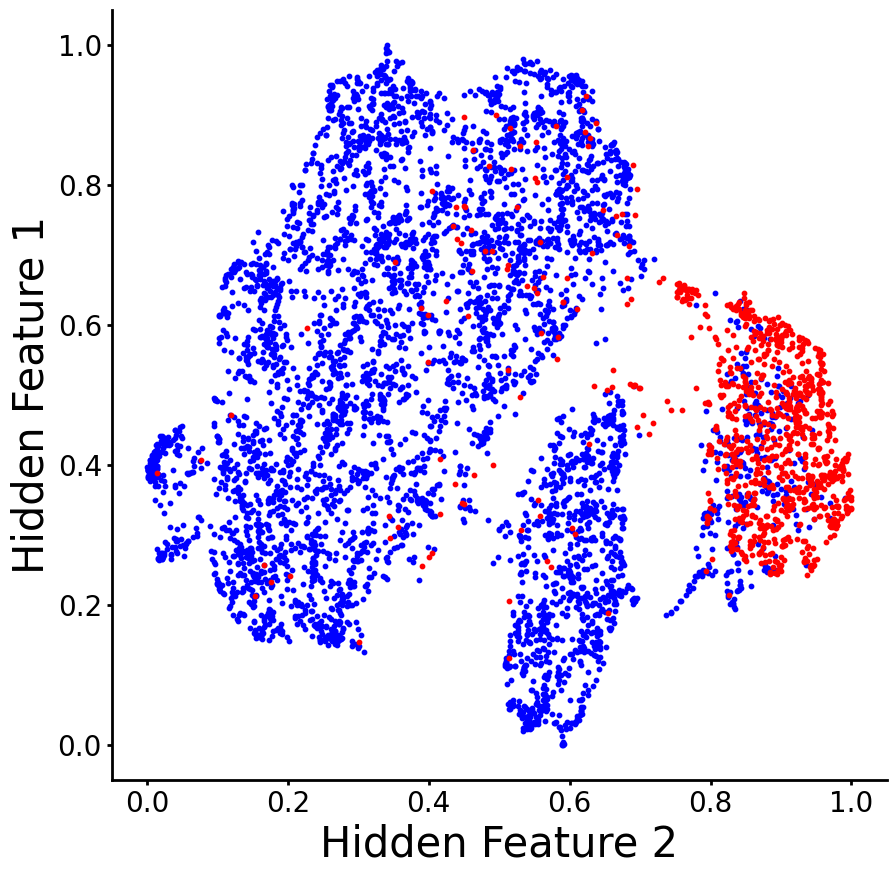

In [ ]:
# Plot 2D embedding on single canvas
fs = 10
fig, ax = plt.subplots(1, 1, figsize=(fs, fs))

# Scatter plot
_ = ax.scatter(embeds_2d[:len(embeds_rplan), 0], embeds_2d[:len(embeds_rplan), 1], c='blue', alpha=1, s=fs)
_ = ax.scatter(embeds_2d[len(embeds_rplan):, 0], embeds_2d[len(embeds_rplan):, 1], c='red', alpha=1, s=fs)

# Make up spines
ax.spines['bottom'].set_linewidth(fs/5)
ax.spines['left'].set_linewidth(fs/5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Make up ticks
ax.tick_params(axis='both', width=fs/5, labelsize=fs*2)

# Make up labels
_ = ax.set_ylabel("Hidden Feature 1", fontsize=fs*3)
_ = ax.set_xlabel("Hidden Feature 2", fontsize=fs*3)

Each point in the scatter plot represents one floor plan.
The blue ones are floor plans from RPLAN; the red ones from MSD.



When we want to visualize the floor plans on top the positions (embeddings), it might be nicer to create a ***grid-like embedding space***.

Let's create a 2D grid ourselves within (0, 1) and find for every grid point the closest point (again: by Euclidean distance) in the floor plan population. Two important details: 1) we do not allow a floor plan to be plotted twice and 2) if a grid point is too far away (>`min_dist`) from each floor plan embedding, the grid point will be empty. Now we consider the identity that corresponds to that as the floor plan that needs to be plotted at that specific grid position.

In [ ]:
from utils import get_grid_embeddings  # Note: our library

w = h = 60
embeds_grid, names_grid = get_grid_embeddings(embeds_2d, names, w=w, h=h)

100%|██████████| 3481/3481 [00:02<00:00, 1215.91it/s]


Let's check how many floor plans we still have.
(Note that some are 'removed' by the algorithm above.)

In [ ]:
print(f"Amount of floor plans considered: {len(names_grid)}")

# Find the number of names that are integers (i.e., from RPLAN)
ints = [n for n in names_grid if isinstance(n, int)]

Amount of floor plans considered: 1506


And again, create a scatterplot.

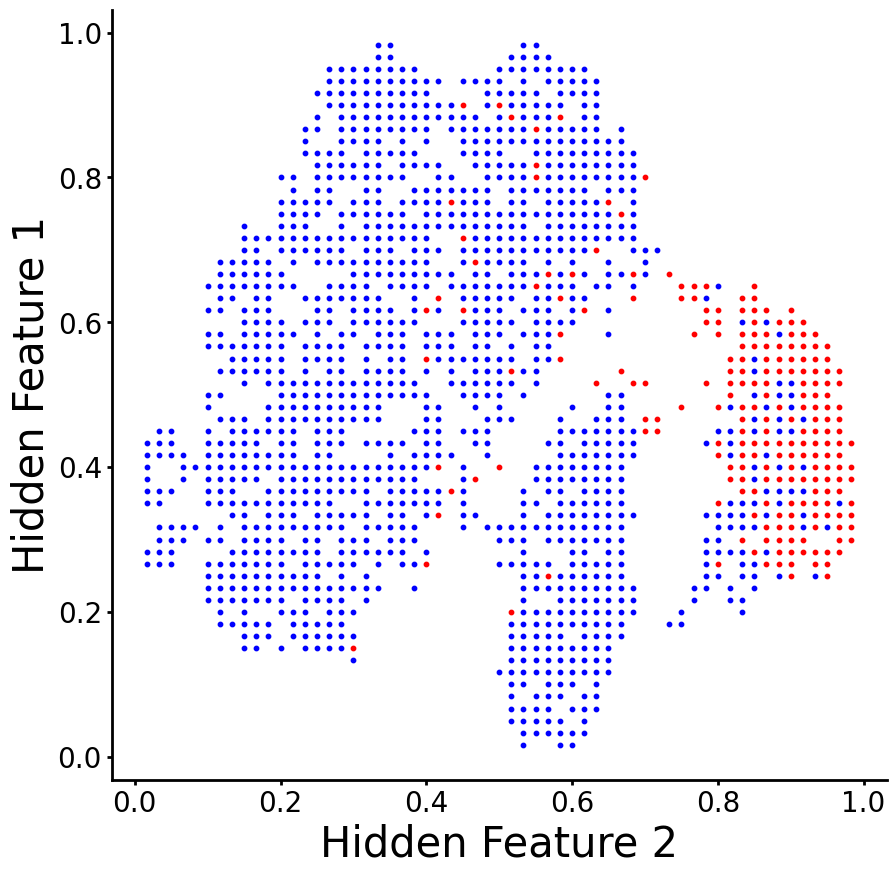

In [ ]:
# Plot 2D embedding on single canvas
fs = 10
fig, ax = plt.subplots(1, 1, figsize=(fs, fs))

# Scatter plot
_ = ax.scatter(embeds_grid[:len(ints), 0], embeds_grid[:len(ints), 1], c='blue', alpha=1, s=fs)
_ = ax.scatter(embeds_grid[len(ints):, 0], embeds_grid[len(ints):, 1], c='red', alpha=1, s=fs)

# Make up spines
ax.spines['bottom'].set_linewidth(fs/5)
ax.spines['left'].set_linewidth(fs/5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Make up ticks
ax.tick_params(axis='both', width=fs/5, labelsize=fs*2)

# Make up labels
_ = ax.set_ylabel("Hidden Feature 1", fontsize=fs*3)
_ = ax.set_xlabel("Hidden Feature 2", fontsize=fs*3)

### Dataset visualization

In [ ]:
from tqdm import tqdm
from shapely.geometry import Polygon

def draw_square(ax, size, center, color="r", lw=0.5):

    x, y = center
    half_s = size / 2

    # Define square corners (in clockwise or counter-clockwise order)
    square = [
        (x - half_s, y - half_s),
        (x - half_s, y + half_s),
        (x + half_s, y + half_s),
        (x + half_s, y - half_s),
        (x - half_s, y - half_s)  # close the square
    ]

    # Unzip into X and Y coordinates
    xs, ys = zip(*square)

    ax.plot(xs, ys, f'{color}-', linewidth=lw)


def draw_dataset(graphs, names, embeds_grid, names_grid, w, fs=50, stop=-1):

    # Set sizing of the floor plans based on the grid and original sizes
    size = (1/w) * (1.1 / 2)

    # Initialize figure
    fig, ax = plt.subplots(1, 1, figsize=(fs, fs))
    ax.set_aspect('equal')

    # Ax set limits
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])

    # Make up spines
    ax.spines['bottom'].set_linewidth(fs/5)
    ax.spines['left'].set_linewidth(fs/5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Make up ticks
    ax.tick_params(axis='both', width=fs/5, labelsize=fs*2)

    # Make up labels
    _ = ax.set_ylabel("Hidden Feature 1", fontsize=fs*3)
    _ = ax.set_xlabel("Hidden Feature 2", fontsize=fs*3)

    for id, feat in tqdm(zip(names_grid[:stop], embeds_grid[:stop])):

        # Find G by indexing the name
        G = graphs[names.index(id)]

        # Translate polygons and centers based on the embeddings
        polygons = [Polygon(np.array(d) * size - size / 2 + feat) for _, d in G.nodes('polygon')]
        pos = {n: np.array(
            [Polygon(d).representative_point().x,
            Polygon(d).representative_point().y]) * size - size / 2 + feat
            for n, d in G.nodes('polygon')}

        # Draw floor plan and graph
        draw_graph(ax, G, polygons=polygons, pos=pos, fs=fs, s=fs/6, w=fs/80, lw=fs/100)

        if id in ids_rplan:
            draw_square(ax, size*1.7, feat - size*0.5, color="b", lw=fs/30)
        else:
            draw_square(ax, size*1.7, feat - size*0.5, color="r", lw=fs/30)

1505it [00:34, 44.24it/s]


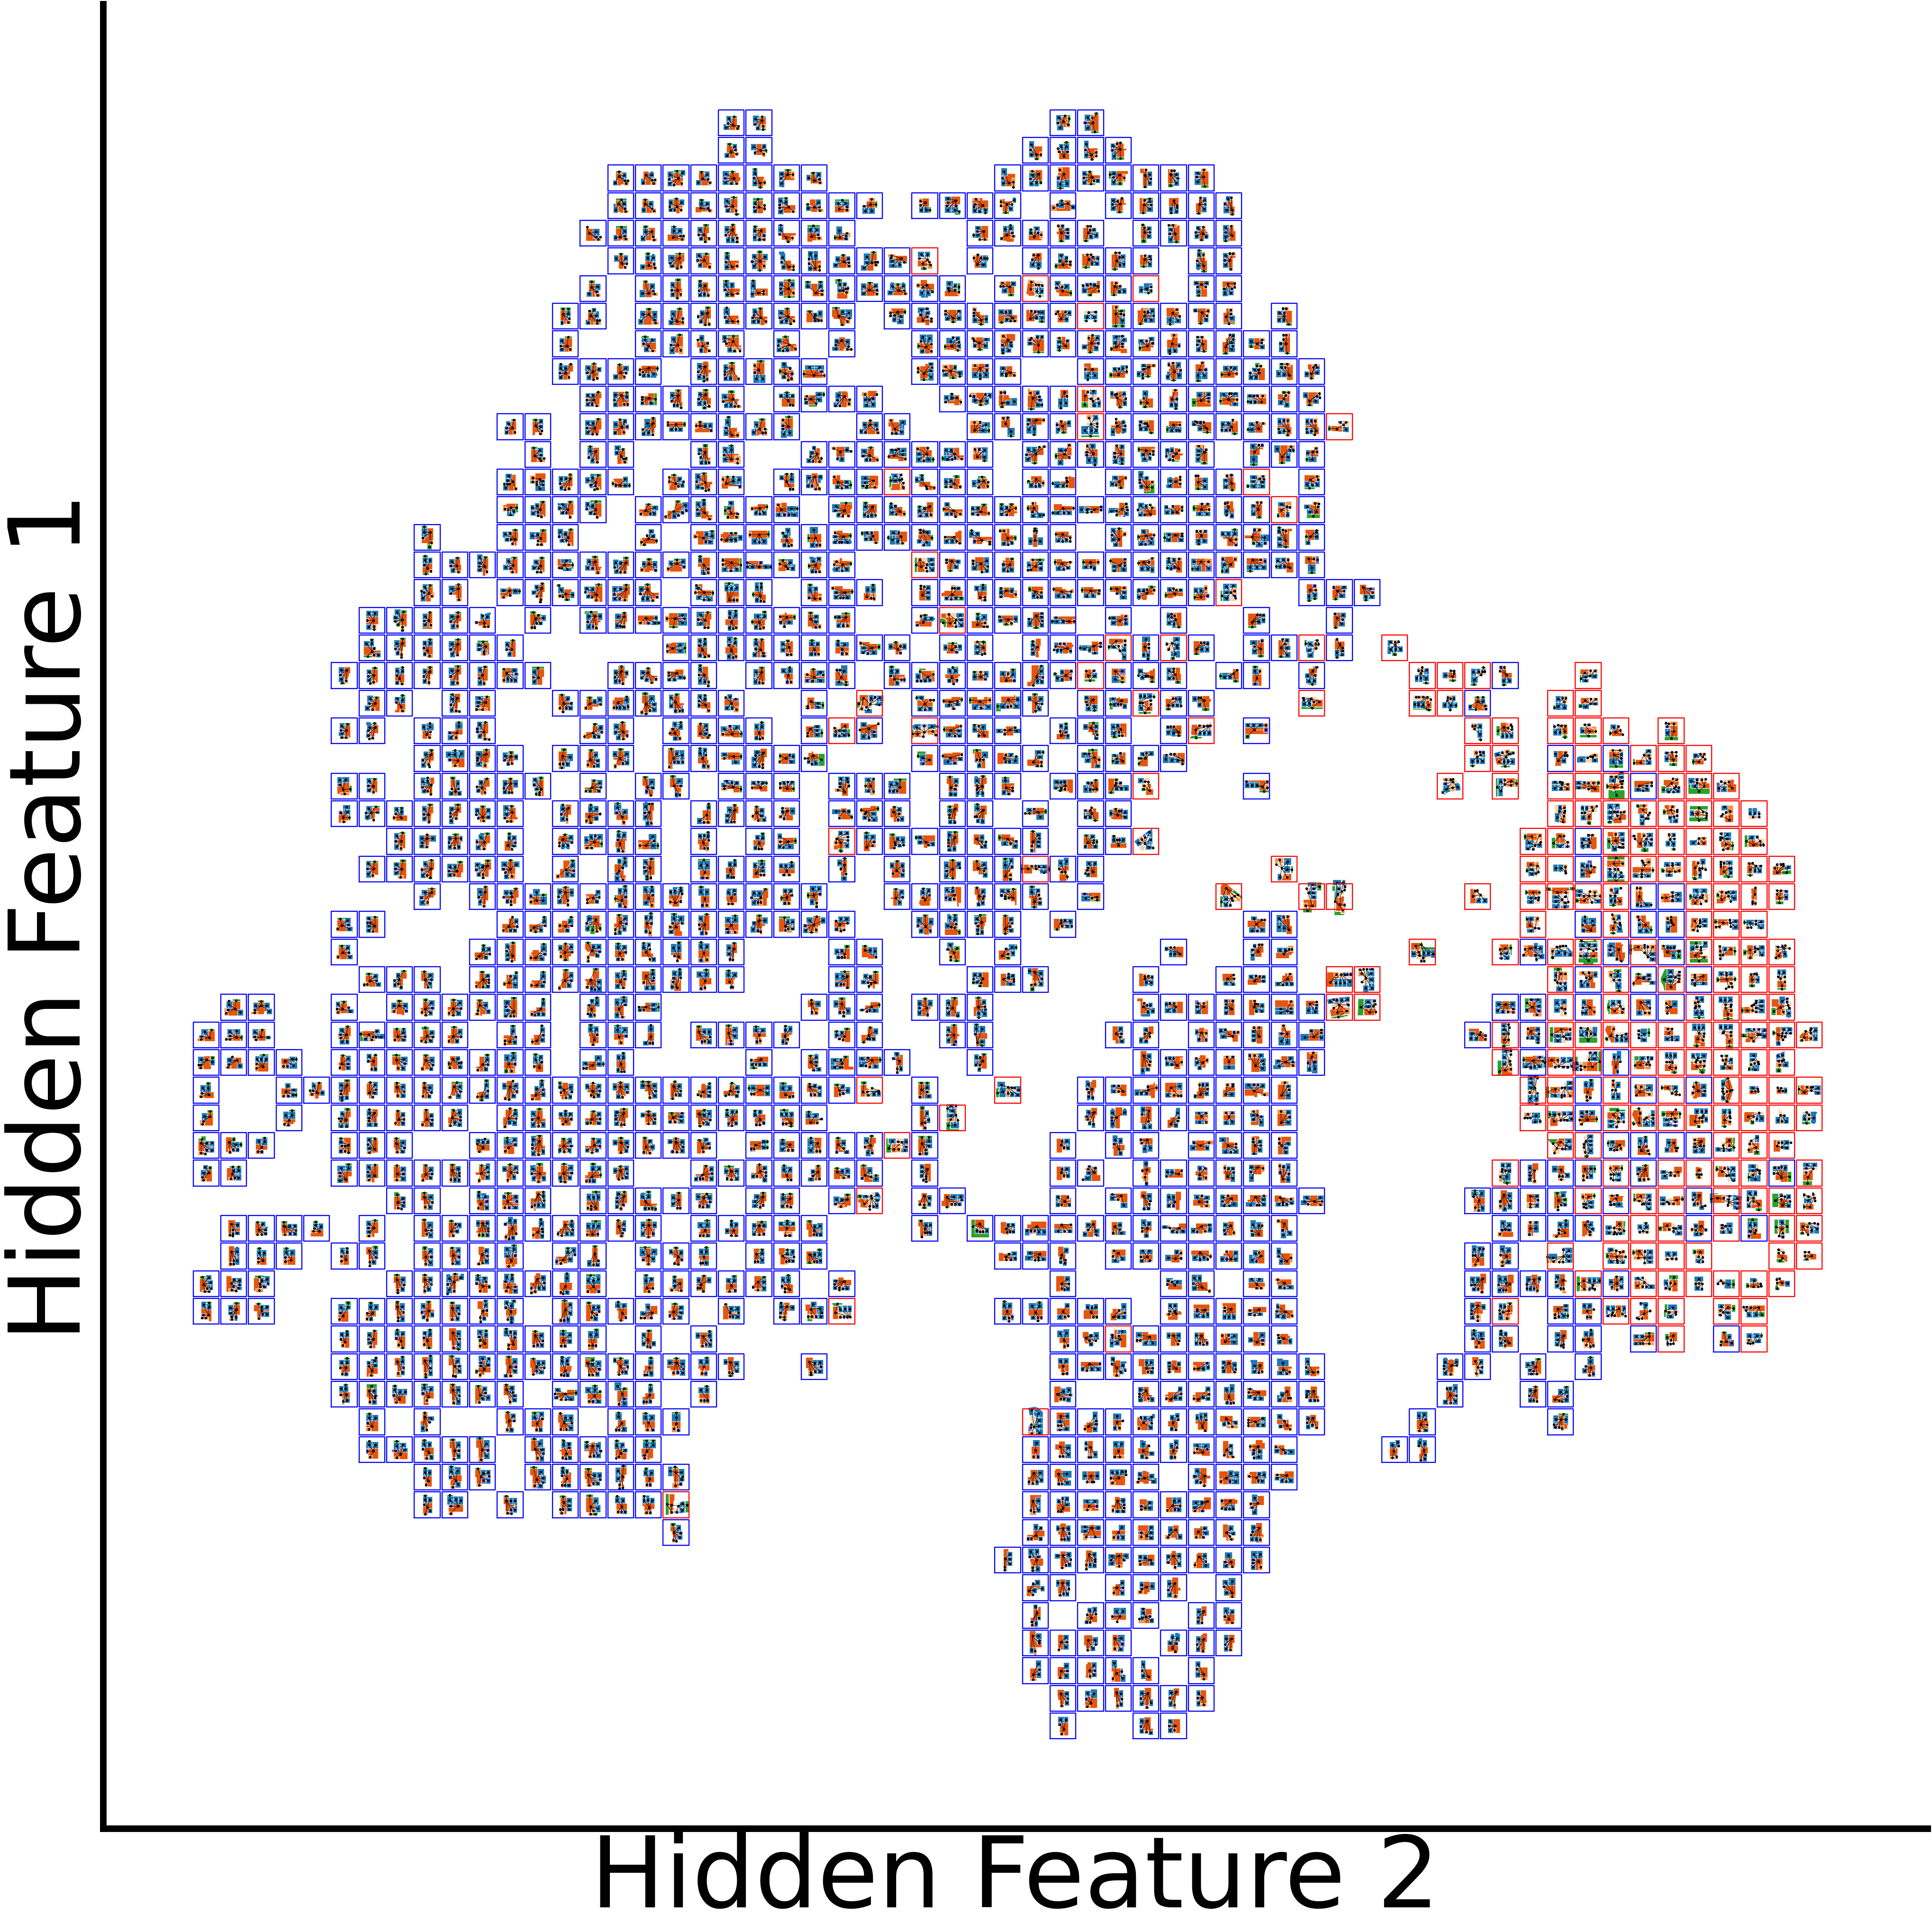

In [ ]:
# from utils import draw_dataset  # Note: our library

draw_dataset(graphs, names, embeds_grid, names_grid, w=w, fs=50)

## **(2) Assignment**

In the assignment you will work with the floor plans from your own projects.
You will receive the floor plans per group.
The floor plans will be uploaded to the same shared folder in the Drive.

**Code**
- Load graphs (1pt)
- Compute embeddings (1pt)
- Use UMAP to get 2D embeddings (1pt)
- Show scatter data against RPLAN (and, if you like, MSD) in different colors (2pt)
- Visualize dataset on top of the 2D embeddings (1pt)

**Evaluation**
- Does the model generalize to your data? What features does the model (not) focus on? Connectivity or shapes or semantics or all? Please elaborate (2pt)
- What can you say about the diversity of your data given the dataset visualization? Please elaborate (2pt)

**Extra: 1D similarity**
- Pick a couple of random floor plans from your project (or RPLAN or MSD). Compute the 10 closest floor plans based on the embeddings that come out of the model (e.g., using the Euclidean distance, see previous tutorials!). This might help you understand the questions under Evaluation even better. You can earn 2 bonus points here.
